In [1]:
import torch
import torchvision
import numpy as np
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random

rescale_height = 800

#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
downloaded_dir = repo_dir + "downloaded-data/"
save_dir = downloaded_dir + "saved-labels/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(downloaded_dir):
    os.makedirs(downloaded_dir)

labelled_filenames = os.listdir(save_dir)
img_num = 1
for filename in labelled_filenames:
    img_num = max(img_num, int(filename.split("_")[0])+1)
print(f"Starting on img_num: {img_num}")

# if not os.path.exists(downloaded_dir+/golfdb-entire-image):

#download and unzip kaggle data, stored in downloaded-data
# !kaggle datasets download -d andrewmvd/3d-golf-swing-dataset
# https://www.kaggle.com/datasets/marcmarais/golfdb-entire-image


images_left_path = f'{downloaded_dir}/images_left.txt'
#check if exists
if not os.path.exists(images_left_path):
    golfdb_dir = downloaded_dir + 'golfdb/Swing_events/'
    golfdb_foldernames = os.listdir(golfdb_dir)

    image_paths = []
    for foldername in golfdb_foldernames:
        folder_path = golfdb_dir + foldername + "/"
        folder_image_paths = [folder_path + x for x in os.listdir(folder_path)]
        image_paths += folder_image_paths
    random.shuffle(image_paths)
    print(len(image_paths), image_paths[:2])

    with open(images_left_path, 'w') as f:
        f.write("\n".join(image_paths))

    with open(f'{downloaded_dir}/backup.txt', 'w') as f:
        f.write("\n".join(image_paths))

# img = cv2.imread(downloaded_dir + 'golfdb/Swing_events/Address/0.jpg')
# display(Image.fromarray(img[:,:,::-1]))

def label_img(img, club_coordinates):
    grip, club = club_coordinates

    labelled = img.copy()
    cv2.circle(labelled, grip, 5, (255,0,255), -1)
    cv2.circle(labelled, club, 5, (255,0,255), -1)
    cv2.line(labelled, club, grip, (255, 0, 0), 2)
    
    box_buffer = max(img.shape[:2])//20
    box_cords = [[max(min(grip[0], club[0])-box_buffer, 1), max(min(grip[1], club[1])-box_buffer, 1)], #top left cord
            [min(max(grip[0], club[0])+box_buffer, img.shape[0]-1), min(max(grip[1], club[1])+box_buffer, img.shape[1]-1)]] # bottom right cord
    cv2.rectangle(labelled, box_cords[0], box_cords[1], (0, 0, 255), 2)
    return labelled, grip, club, box_cords

def click_event_label(event, x, y, flags, params):
        # checking for left mouse clicks or right mouse clicks
        if event==cv2.EVENT_RBUTTONDOWN:
            global skip
            skip = True
        if event == cv2.EVENT_LBUTTONDOWN:
            global golf_club_coordinates
            golf_club_coordinates.append([int(x),int(y)])

def click_event_save(event, x, y, flags, params):
    # checking for left mouse clicks or right mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        global save
        save = True
    elif event == cv2.EVENT_RBUTTONDOWN:
        global redo
        redo = True

loop = True
while loop:
    #really images will be filename and file will be loaded in first name
    #check if file exists
    with open(images_left_path, 'r') as fin:
        data = fin.read().splitlines(True)
    filepath = data[0][:-1] # removing \n at end
    img = cv2.imread(filepath)

    #### Rescale image
    h, w = img.shape[:2]
    r = rescale_height / float(h)
    dim = (int(w * r), rescale_height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    ### Labelled images in window
    golf_club_coordinates = []
    skip = False
        
    cv2.imshow('image', resized)
    cv2.setWindowProperty('image', cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback('image', click_event_label)
    while len(golf_club_coordinates) != 2:
        if skip:
            break
        k = cv2.waitKey(100)

        if k == 27:
            print("Ending loop.")
            loop = False
            cv2.destroyWindow('image') #make sure window closes cleanly
            break
    if not loop:
        break

    if skip:
        with open(images_left_path, 'r') as fin:
            data = fin.read().splitlines(True)
        with open(images_left_path, 'w') as fout:
            fout.writelines(data[1:])
        continue

    ### Annotate labels on images
    labelled, grip, club, box_cords = label_img(resized, golf_club_coordinates)
    save = False
    redo = False

    cv2.imshow('image', labelled)
    cv2.setWindowProperty('image', cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback('image', click_event_save)
    while not (save or redo):
        k = cv2.waitKey(100)
        if k == 27:
            print("Ending loop.")
            loop = False
            cv2.destroyWindow('image') #make sure window closes cleanly
            break
    if not loop:
        break
    
    if save:
        save_filename = f"{img_num}_"
        for x, y in [grip] + [club]:
            save_filename += f"{x}-{y}-"
        save_filename = save_filename[:-1] +  "_.png"
        save_path = save_dir + save_filename
        cv2.imwrite(save_path, resized)

        img_num+=1
        with open(images_left_path, 'r') as fin:
            data = fin.read().splitlines(True)
        with open(images_left_path, 'w') as fout:
            fout.writelines(data[1:])
    # else:
    #     print("redoing image")

print(f"Ending on img_num: {img_num}")

Starting on img_num: 29
Ending loop.
Ending on img_num: 29


len(dataset): 1
[141, 149, 1.0] [375, 404, 1.0]
batch[0] list containing 1 tensors of shape torch.Size([3, 800, 800]):
batch[1] list containing 1 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


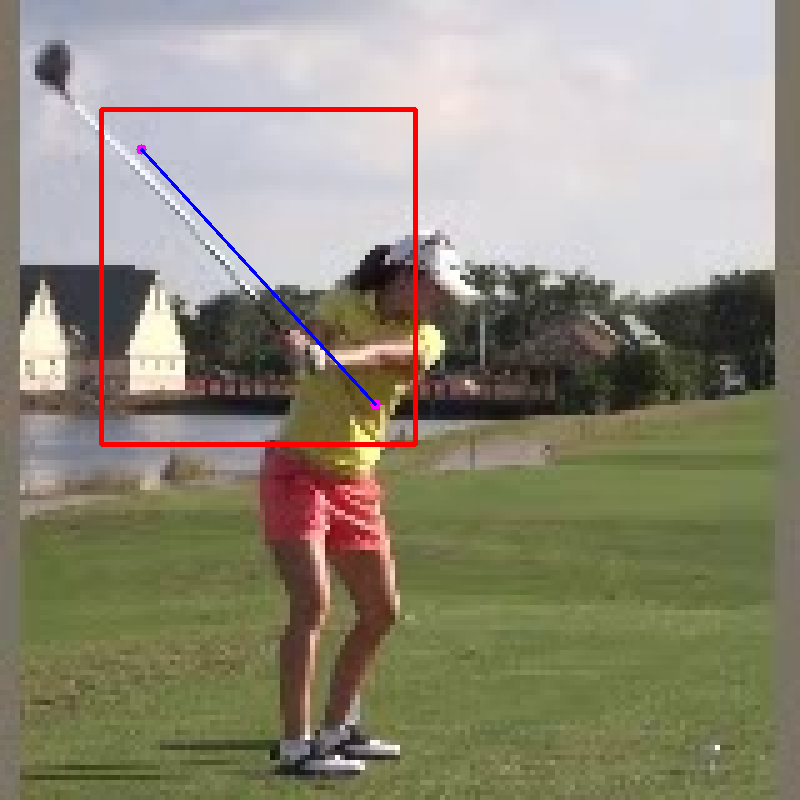

In [6]:
######## Visualizing dataset ########

import torch
import torchvision
import numpy as np
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random


#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"


# This checks it is definitely in the right format
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        # transforms = []
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        # img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, club = cords[:2], cords[2:]
        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], club[0])-box_buffer, 1),
            max(min(grip[1], club[1])-box_buffer, 1), #top left cord
            min(max(grip[0], club[0])+box_buffer, img.shape[0]-1),
            min(max(grip[1], club[1])+box_buffer, img.shape[1]-1)] # bottom right cord
        
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img).to(self.device)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        
        grip.append(1.) # for visibility argument
        club.append(1.)
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64).to(self.device)
        print(grip, club)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
       
        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=True)
print("len(dataset):", len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=32, shuffle=False)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))